In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-0ngfq995
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-0ngfq995
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=d76968ea178c9f8df7e49af02d298fb70a595345a5c3719581d983e30914e328
  Stored in directory: /tmp/pip-ephem-wheel-cache-62rlo473/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image-classifiers


In [ ]:
!pip install 'tensorflow_graphics'

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import cv2
from classification_models.keras import Classifiers
from classification_models.tfkeras import Classifiers
from sklearn.model_selection import train_test_split

<ipython-input-5-5974fa4f89fe>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/covers/classification_images.zip -d /content/classification

## Load Models

In [ ]:
Classifiers.models_names()

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'seresnet18',
 'seresnet34',
 'seresnet50',
 'seresnet101',
 'seresnet152',
 'seresnext50',
 'seresnext101',
 'senet154',
 'resnet50v2',
 'resnet101v2',
 'resnet152v2',
 'resnext50',
 'resnext101',
 'vgg16',
 'vgg19',
 'densenet121',
 'densenet169',
 'densenet201',
 'inceptionresnetv2',
 'inceptionv3',
 'xception',
 'nasnetlarge',
 'nasnetmobile',
 'mobilenet',
 'mobilenetv2']

# Pre-process Images

In [ ]:
image_dir = '/content/classification'
image_size = (224, 224)
batch_size = 32

In [ ]:
def image_generator(image_dir, batch_size, image_size):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            filepath = os.path.join(image_dir, filename)
            label = filename.split('_')[0]  # Extract the label from the filename

            # Load and preprocess the image
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, image_size)  # Resize the image
            image = image / 255.0  # Normalize pixel values to the range of 0-1

            images.append(image)
            labels.append(label)

            if len(images) == batch_size:
                yield np.array(images), np.array(labels)
                images = []
                labels = []

    if images:  # Yield the remaining images if the total count is not a multiple of batch_size
        yield np.array(images), np.array(labels)

In [ ]:
# Generate the data using the image generator
data_generator = image_generator(image_dir, batch_size, image_size)
X, y = zip(*data_generator)

# Convert the generator output to arrays
X = np.concatenate(X)
y = np.concatenate(y)

# Split the dataset into training and testing sets with equal class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Split the training and validation sets with equal class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=123, stratify=y_train_val)


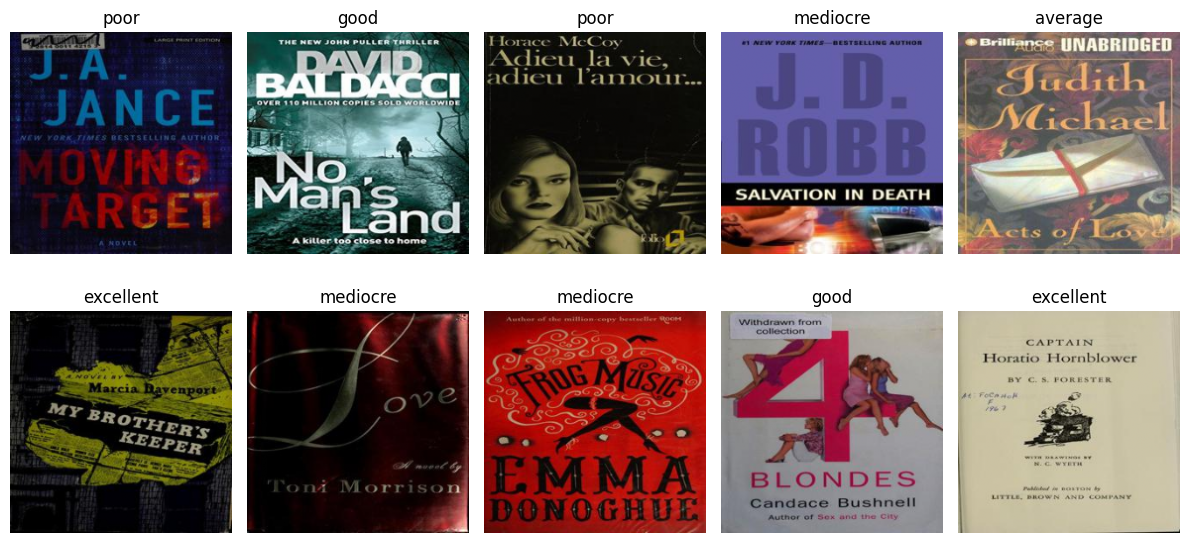

In [ ]:
# Define a function to display images and labels
def display_images(images, labels):
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    axs = axs.ravel()

    for i in range(10):
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display some images and labels from the training set
display_images(X_train[:10], y_train[:10])


In [ ]:
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Val set size:", len(X_val))


Training set size: 5456
Test set size: 1706
Val set size: 1364


In [ ]:
# Get the count of unique classes in the training set
unique_train_classes, train_class_counts = np.unique(y_train, return_counts=True)
print("Class counts in the training set:")
for cls, count in zip(unique_train_classes, train_class_counts):
    print(f"Class {cls}: {count} samples")

# Get the count of unique classes in the test set
unique_test_classes, test_class_counts = np.unique(y_test, return_counts=True)
print("Class counts in the test set:")
for cls, count in zip(unique_test_classes, test_class_counts):
    print(f"Class {cls}: {count} samples")

# Get the count of unique classes in the val set
unique_val_classes, test_val_counts = np.unique(y_val, return_counts=True)
print("Class counts in the val set:")
for cls, count in zip(unique_val_classes, test_val_counts):
    print(f"Class {cls}: {count} samples")


Class counts in the training set:
Class average: 935 samples
Class excellent: 1092 samples
Class good: 922 samples
Class mediocre: 902 samples
Class poor: 1605 samples
Class counts in the test set:
Class average: 293 samples
Class excellent: 341 samples
Class good: 288 samples
Class mediocre: 282 samples
Class poor: 502 samples
Class counts in the val set:
Class average: 234 samples
Class excellent: 273 samples
Class good: 231 samples
Class mediocre: 225 samples
Class poor: 401 samples


In [ ]:
# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train_encoded, num_classes=5)
y_test = to_categorical(y_test_encoded, num_classes=5)
y_val = to_categorical(y_val_encoded, num_classes=5)

# Reverse the one-hot encoding and get the original label names
reverse_mapping = {index: label for index, label in enumerate(label_encoder.inverse_transform(range(len(label_encoder.classes_))))}

# Create a mapping dictionary for later use
mapping_dict = {index: category for index, category in reverse_mapping.items()}

# Print the mapping values to the categorical labels
for index, category in mapping_dict.items():
    print(f"Value: {index} - Category: {category}")


Value: 0 - Category: average
Value: 1 - Category: excellent
Value: 2 - Category: good
Value: 3 - Category: mediocre
Value: 4 - Category: poor


In [ ]:
mapping_dict

{0: 'average', 1: 'excellent', 2: 'good', 3: 'mediocre', 4: 'poor'}

# Classification Models

## VGG19

### Train Model

In [ ]:
# Load the pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss and accuracy from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Display loss and accuracy during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'VGG19_weights.h5'))

80134624/80134624 [==============================] - 4s 0us/step
Epoch 1/100
171/171 [==============================] - 18s 49ms/step - loss: 1.6005 - accuracy: 0.2802 - val_loss: 1.5935 - val_accuracy: 0.2837
Epoch 2/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5633 - accuracy: 0.2986 - val_loss: 1.5655 - val_accuracy: 0.3065
Epoch 3/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5469 - accuracy: 0.3176 - val_loss: 1.5595 - val_accuracy: 0.3152
Epoch 4/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5408 - accuracy: 0.3204 - val_loss: 1.5601 - val_accuracy: 0.3204
Epoch 5/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5268 - accuracy: 0.3224 - val_loss: 1.5601 - val_accuracy: 0.3174
Epoch 6/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5233 - accuracy: 0.3354 - val_loss: 1.5594 - val_accuracy: 0.3101
Epoch 7/100
171/171 [==============================] - 6s 33ms/step - 

In [ ]:
# Evaluate the model
VGG19_test_loss, VGG19_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", VGG19_test_loss)
print("Test Accuracy:", VGG19_test_accuracy)


#### Confusion Matrix

54/54 [==============================] - 1s 24ms/step


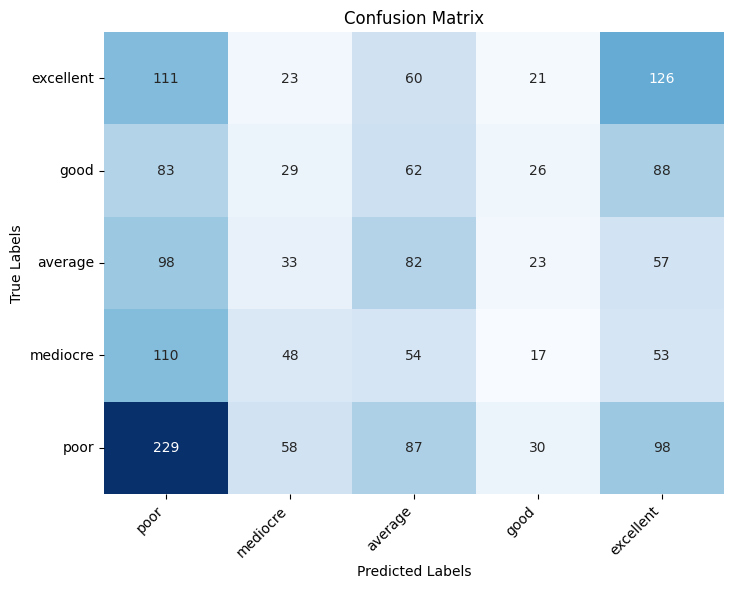

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


### Hyperparameter tuning

In [ ]:
# Function to create the model
def create_model(learning_rate):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters and results
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

# Get the best model
best_model = grid_result.best_estimator_

# Train the best model and display loss and accuracy
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss and accuracy from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Display loss and accuracy during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
best_model.model.save_weights(os.path.join(save_dir, 'hyper_VGG19_weights.h5'))


<ipython-input-21-ad9b1ef89607>:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


Best Parameters:  {'learning_rate': 0.001}
Best Score:  0.29875515898068744
Epoch 1/10
Train Loss: 1.5922 - Train Accuracy: 0.2826
Validation Loss: 1.5790 - Validation Accuracy: 0.2999

Epoch 2/10
Train Loss: 1.5635 - Train Accuracy: 0.3061
Validation Loss: 1.5731 - Validation Accuracy: 0.3123

Epoch 3/10
Train Loss: 1.5519 - Train Accuracy: 0.3065
Validation Loss: 1.5655 - Validation Accuracy: 0.3013

Epoch 4/10
Train Loss: 1.5440 - Train Accuracy: 0.3218
Validation Loss: 1.5860 - Validation Accuracy: 0.2969

Epoch 5/10
Train Loss: 1.5298 - Train Accuracy: 0.3317
Validation Loss: 1.5597 - Validation Accuracy: 0.3240

Epoch 6/10
Train Loss: 1.5238 - Train Accuracy: 0.3371
Validation Loss: 1.5604 - Validation Accuracy: 0.3196

Epoch 7/10
Train Loss: 1.5139 - Train Accuracy: 0.3482
Validation Loss: 1.5656 - Validation Accuracy: 0.3152

Epoch 8/10
Train Loss: 1.5107 - Train Accuracy: 0.3411
Validation Loss: 1.6013 - Validation Accuracy: 0.2991

Epoch 9/10
Train Loss: 1.5014 - Train Accura

### Fine Tuning

#### Load Weights

In [ ]:
# Load the pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/hyper_VGG19_weights.h5'
model.load_weights(weights_path)



In [ ]:
# Evaluate the model
hyper_VGG19_test_loss, hyper_VGG19_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_VGG19_test_loss)
print("Test Accuracy:", hyper_VGG19_test_accuracy)


54/54 [==============================] - 2s 26ms/step - loss: 1.5739 - accuracy: 0.3113
Test Loss: 1.5739139318466187
Test Accuracy: 0.3112543821334839


In [ ]:
# Load the pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Unfreeze some layers for fine-tuning
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'fine_VGG19_weights.h5'))


Epoch 1/100
171/171 [==============================] - 8s 40ms/step - loss: 1.6032 - accuracy: 0.2804 - val_loss: 1.5802 - val_accuracy: 0.2837
Epoch 2/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5650 - accuracy: 0.2940 - val_loss: 1.5785 - val_accuracy: 0.2859
Epoch 3/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5518 - accuracy: 0.3176 - val_loss: 1.5797 - val_accuracy: 0.3006
Epoch 4/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5392 - accuracy: 0.3206 - val_loss: 1.5888 - val_accuracy: 0.3094
Epoch 5/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5271 - accuracy: 0.3306 - val_loss: 1.5699 - val_accuracy: 0.3101
Epoch 6/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5206 - accuracy: 0.3301 - val_loss: 1.5668 - val_accuracy: 0.3196
Epoch 7/100
171/171 [==============================] - 6s 33ms/step - loss: 1.5124 - accuracy: 0.3343 - val_loss: 1.5574 - val_accuracy:

In [ ]:
# Evaluate the model
fine_VGG19_test_loss, fine_VGG19_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", fine_VGG19_test_loss)
print("Test Accuracy:", fine_VGG19_test_accuracy)


54/54 [==============================] - 1s 27ms/step - loss: 1.5823 - accuracy: 0.2943
Test Loss: 1.5822715759277344
Test Accuracy: 0.2942555546760559


In [ ]:
# Load the pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/hyper_VGG19_weights.h5'
model.load_weights(weights_path)



219055592/219055592 [==============================] - 14s 0us/step


1/1 [==============================] - 0s 49ms/step


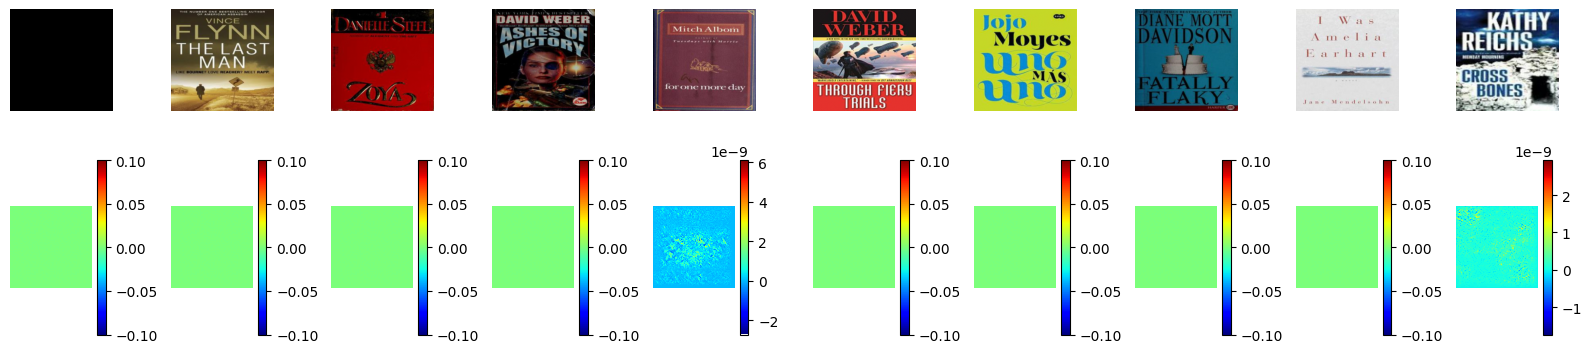

In [ ]:
# Select the first 10 images from X_test
images = X_test[:10]

# Compute the saliency maps for each image
saliency_maps_list = []
for image in images:
    input_image = np.expand_dims(image, axis=0)
    input_tensor = tf.convert_to_tensor(input_image)
    input_tensor = tf.Variable(input_tensor)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
    gradients = tape.gradient(predictions, input_tensor)
    saliency_map = tf.reduce_max(gradients, axis=-1)
    saliency_map = saliency_map[0].numpy()
    saliency_maps_list.append(saliency_map)

# Get the predicted labels for the images
labels = np.argmax(model.predict(images), axis=1)

# Display the original images and saliency maps with labels
fig, axes = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    im = axes[1, i].imshow(saliency_maps_list[i], cmap='jet')
    axes[1, i].axis('off')
    fig.colorbar(im, ax=axes[1, i])
plt.tight_layout()
plt.show()

## ResNeXt101

### Train Model

In [ ]:
ResNeXt101, preprocess_input = Classifiers.get('resnext101')

# Define the input shape
input_shape = (224, 224, 3)

# Load the base model
base_model = ResNeXt101(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Add a custom top to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss and accuracy from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Display loss and accuracy during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'ResNeXt101_weights.h5'))


173622728/173622728 [==============================] - 8s 0us/step
Epoch 1/10
171/171 [==============================] - 61s 157ms/step - loss: 1.6858 - accuracy: 0.2570 - val_loss: 1.5838 - val_accuracy: 0.2940
Epoch 2/10
171/171 [==============================] - 15s 89ms/step - loss: 1.5936 - accuracy: 0.2933 - val_loss: 1.5826 - val_accuracy: 0.2940
Epoch 3/10
171/171 [==============================] - 15s 88ms/step - loss: 1.5878 - accuracy: 0.2942 - val_loss: 1.5845 - val_accuracy: 0.2940
Epoch 4/10
171/171 [==============================] - 15s 89ms/step - loss: 1.5886 - accuracy: 0.2942 - val_loss: 1.5831 - val_accuracy: 0.2940
Epoch 5/10
171/171 [==============================] - 15s 89ms/step - loss: 1.5872 - accuracy: 0.2942 - val_loss: 1.5877 - val_accuracy: 0.2940
Epoch 6/10
171/171 [==============================] - 15s 89ms/step - loss: 1.5871 - accuracy: 0.2942 - val_loss: 1.5848 - val_accuracy: 0.2940
Epoch 7/10
171/171 [==============================] - 15s 88ms/step 

#### Load Model

In [ ]:
ResNeXt101, preprocess_input = Classifiers.get('resnext101')

# Define the input shape
input_shape = (224, 224, 3)

# Load the base model
base_model = ResNeXt101(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Add a custom top to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/ResNeXt101_weights.h5'
model.load_weights(weights_path)



In [ ]:
# Evaluate the model
ResNeXt101_test_loss, ResNeXt101_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", ResNeXt101_test_loss)
print("Test Accuracy:", ResNeXt101_test_accuracy)


54/54 [==============================] - 20s 74ms/step - loss: 1.5825 - accuracy: 0.2943
Test Loss: 1.5825114250183105
Test Accuracy: 0.2942555546760559


#### Confusion Matrix

54/54 [==============================] - 14s 63ms/step


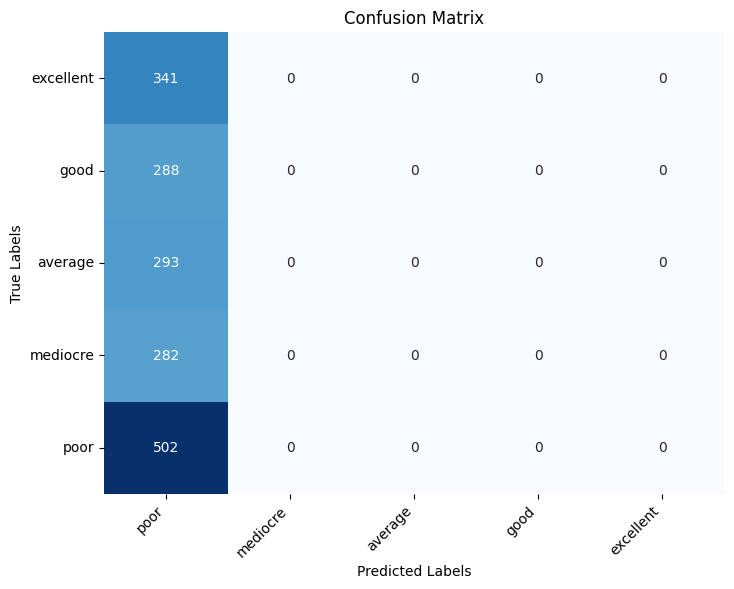

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


### Hyperparameter tuning

In [ ]:
# Define the model building function
def build_model(hp):
    ResNeXt101, preprocess_input = Classifiers.get('resnext101')

    # Define the input shape
    input_shape = (224, 224, 3)

    # Load the base model
    base_model = ResNeXt101(weights='imagenet', include_top=False, input_shape=input_shape)


    # Add custom layers on top of the base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='hyperparameter_tuning')

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'hyper_resnext101_weights.h5'))

In [ ]:
# Evaluate the model
hyper_resnext101_test_loss, hyper_resnext101_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_resnext101_test_loss)
print("Test Accuracy:", hyper_resnext101_test_accuracy)

54/54 [==============================] - 9s 74ms/step - loss: 1.5825 - accuracy: 0.2943
Test Loss: 1.5825114250183105
Test Accuracy: 0.2942555546760559


### Fine Tuning

In [ ]:
ResNeXt101, preprocess_input = Classifiers.get('resnext101')

# Load the pre-trained model
base_model = ResNeXt101(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/hyper_resnext101_weights.h5'
model.load_weights(weights_path)

In [ ]:
# Evaluate the model
hyper_ResNeXt101_test_loss, hyper_ResNeXt101_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_ResNeXt101_test_loss)
print("Test Accuracy:", hyper_ResNeXt101_test_accuracy)


54/54 [==============================] - 21s 74ms/step - loss: 1.6097 - accuracy: 0.1940
Test Loss: 1.609669804573059
Test Accuracy: 0.1940211057662964


In [ ]:
# Load the pre-trained model
base_model = ResNeXt101(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Unfreeze some layers for fine-tuning
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'fine_ResNeXt101_weights.h5'))


Epoch 1/100
171/171 [==============================] - 60s 152ms/step - loss: 1.6526 - accuracy: 0.2597 - val_loss: 1.6079 - val_accuracy: 0.2001
Epoch 2/100
171/171 [==============================] - 15s 87ms/step - loss: 1.6103 - accuracy: 0.2718 - val_loss: 1.5901 - val_accuracy: 0.2940
Epoch 3/100
171/171 [==============================] - 15s 88ms/step - loss: 1.5956 - accuracy: 0.2826 - val_loss: 1.5916 - val_accuracy: 0.2940
Epoch 4/100
171/171 [==============================] - 15s 87ms/step - loss: 1.5915 - accuracy: 0.2868 - val_loss: 1.5874 - val_accuracy: 0.2940
Epoch 5/100
171/171 [==============================] - 15s 87ms/step - loss: 1.5883 - accuracy: 0.2896 - val_loss: 1.5868 - val_accuracy: 0.2940
Epoch 6/100
171/171 [==============================] - 15s 88ms/step - loss: 1.5854 - accuracy: 0.2942 - val_loss: 1.5826 - val_accuracy: 0.2940
Epoch 7/100
171/171 [==============================] - 15s 88ms/step - loss: 1.5860 - accuracy: 0.2942 - val_loss: 1.5883 - val_a

In [ ]:
ResNeXt101, preprocess_input = Classifiers.get('resnext101')

# Load the pre-trained model
base_model = ResNeXt101(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/fine_ResNeXt101_weights.h5'
model.load_weights(weights_path)

In [ ]:
# Evaluate the model
fine_ResNeXt101_test_loss, fine_ResNeXt101_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", fine_ResNeXt101_test_loss)
print("Test Accuracy:", fine_ResNeXt101_test_accuracy)

54/54 [==============================] - 20s 69ms/step - loss: 1.5759 - accuracy: 0.2943
Test Loss: 1.5759234428405762
Test Accuracy: 0.2942555546760559


## InceptionV3

### Train Model

In [ ]:
InceptionV3, preprocess_input = Classifiers.get('inceptionv3')

# Load the pre-trained model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and display loss and accuracy
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss and accuracy from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Display loss and accuracy during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'InceptionV3_weights.h5'))

87910968/87910968 [==============================] - 6s 0us/step
Epoch 1/100
171/171 [==============================] - 12s 40ms/step - loss: 1.6572 - accuracy: 0.2797 - val_loss: 1.5668 - val_accuracy: 0.3043
Epoch 2/100
171/171 [==============================] - 4s 21ms/step - loss: 1.5496 - accuracy: 0.3163 - val_loss: 1.5651 - val_accuracy: 0.2969
Epoch 3/100
171/171 [==============================] - 4s 21ms/step - loss: 1.5309 - accuracy: 0.3224 - val_loss: 1.5478 - val_accuracy: 0.3167
Epoch 4/100
171/171 [==============================] - 4s 21ms/step - loss: 1.4846 - accuracy: 0.3598 - val_loss: 1.5651 - val_accuracy: 0.2969
Epoch 5/100
171/171 [==============================] - 4s 21ms/step - loss: 1.4626 - accuracy: 0.3679 - val_loss: 1.5695 - val_accuracy: 0.2889
Epoch 1/5
Train Loss: 1.6572 - Train Accuracy: 0.2797
Validation Loss: 1.5668 - Validation Accuracy: 0.3043

Epoch 2/5
Train Loss: 1.5496 - Train Accuracy: 0.3163
Validation Loss: 1.5651 - Validation Accuracy: 0.29

In [ ]:
# Evaluate the model
InceptionV3_test_loss, InceptionV3_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", InceptionV3_test_loss)
print("Test Accuracy:", InceptionV3_test_accuracy)

54/54 [==============================] - 1s 25ms/step - loss: 1.5895 - accuracy: 0.2720
Test Loss: 1.5894603729248047
Test Accuracy: 0.27198123931884766


#### Confusion Matrix

54/54 [==============================] - 2s 15ms/step


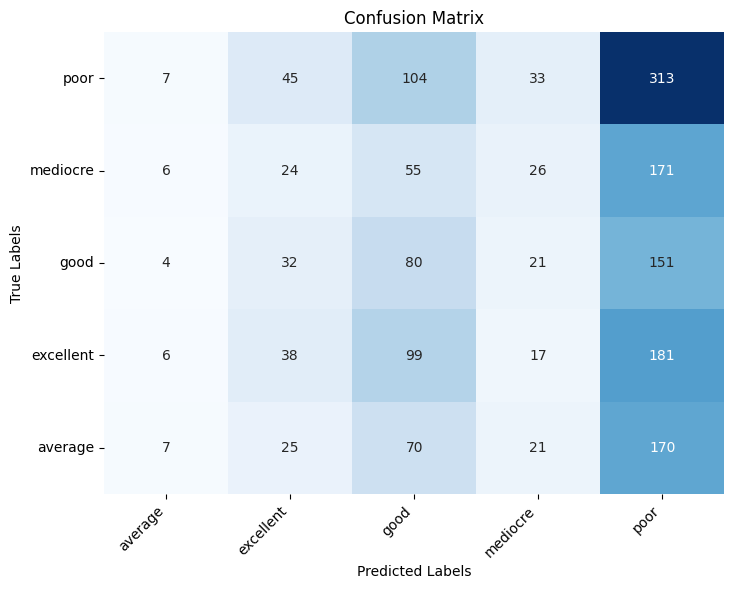

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=list(mapping_dict.values()))

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = list(mapping_dict.values())
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


### Hyperparameter tuning

In [ ]:
# Define the model building function
def build_model(hp):
    # Load the pre-trained model
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Add custom layers on top of the base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='hyperparameter_tuning')

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'hyper_InceptionV3_weights.h5'))

Trial 10 Complete [00h 01m 05s]
val_accuracy: 0.3174486756324768

Best val_accuracy So Far: 0.32184749841690063
Total elapsed time: 00h 03m 11s
Epoch 1/100
171/171 [==============================] - 11s 35ms/step - loss: 1.6595 - accuracy: 0.2674 - val_loss: 1.5670 - val_accuracy: 0.2925
Epoch 2/100
171/171 [==============================] - 4s 22ms/step - loss: 1.5517 - accuracy: 0.3055 - val_loss: 1.5990 - val_accuracy: 0.2661
Epoch 3/100
171/171 [==============================] - 4s 22ms/step - loss: 1.5274 - accuracy: 0.3266 - val_loss: 1.5620 - val_accuracy: 0.3109
Epoch 4/100
171/171 [==============================] - 4s 22ms/step - loss: 1.5037 - accuracy: 0.3484 - val_loss: 1.5568 - val_accuracy: 0.3065
Epoch 5/100
171/171 [==============================] - 4s 22ms/step - loss: 1.4844 - accuracy: 0.3603 - val_loss: 1.5561 - val_accuracy: 0.2823
Epoch 6/100
171/171 [==============================] - 4s 22ms/step - loss: 1.4540 - accuracy: 0.3838 - val_loss: 1.5810 - val_accuracy

In [ ]:
# Evaluate the model
hyper_InceptionV3_test_loss, hyper_InceptionV3_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_InceptionV3_test_loss)
print("Test Accuracy:", hyper_InceptionV3_test_accuracy)

54/54 [==============================] - 1s 17ms/step - loss: 1.8822 - accuracy: 0.3019
Test Loss: 1.8821614980697632
Test Accuracy: 0.3018757402896881


### Fine Tuning

In [ ]:
InceptionV3, preprocess_input = Classifiers.get('inceptionv3')

# Load the pre-trained model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/hyper_InceptionV3_weights.h5'
model.load_weights(weights_path)

In [ ]:
# Evaluate the model
hyper_InceptionV3_test_loss, hyper_InceptionV3_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_InceptionV3_test_loss)
print("Test Accuracy:", hyper_InceptionV3_test_accuracy)

54/54 [==============================] - 3s 18ms/step - loss: 1.8822 - accuracy: 0.3019
Test Loss: 1.8821614980697632
Test Accuracy: 0.3018757402896881


In [ ]:
# Load the pre-trained model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Unfreeze some layers for fine-tuning
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'fine_InceptionV3_weights.h5'))


Epoch 1/100
171/171 [==============================] - 11s 36ms/step - loss: 1.6659 - accuracy: 0.2738 - val_loss: 1.5657 - val_accuracy: 0.2984
Epoch 2/100
171/171 [==============================] - 4s 22ms/step - loss: 1.5585 - accuracy: 0.3101 - val_loss: 1.5664 - val_accuracy: 0.2999
Epoch 3/100
171/171 [==============================] - 4s 22ms/step - loss: 1.5307 - accuracy: 0.3215 - val_loss: 1.5723 - val_accuracy: 0.3152
Epoch 4/100
171/171 [==============================] - 4s 22ms/step - loss: 1.5055 - accuracy: 0.3484 - val_loss: 1.5474 - val_accuracy: 0.3189
Epoch 5/100
171/171 [==============================] - 4s 22ms/step - loss: 1.4722 - accuracy: 0.3657 - val_loss: 1.5910 - val_accuracy: 0.2485
Epoch 6/100
171/171 [==============================] - 4s 22ms/step - loss: 1.4450 - accuracy: 0.3862 - val_loss: 1.6214 - val_accuracy: 0.3138
Epoch 7/100
171/171 [==============================] - 4s 22ms/step - loss: 1.4099 - accuracy: 0.4076 - val_loss: 1.5855 - val_accuracy

In [ ]:
# Load the pre-trained model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/fine_InceptionV3_weights.h5'
model.load_weights(weights_path)

In [ ]:
# Evaluate the model
fine_InceptionV3_test_loss, fine_InceptionV3_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", fine_InceptionV3_test_loss)
print("Test Accuracy:", fine_InceptionV3_test_accuracy)

54/54 [==============================] - 3s 18ms/step - loss: 3.5389 - accuracy: 0.3101
Test Loss: 3.538908004760742
Test Accuracy: 0.3100820779800415


## InceptionResNet-v2

### Train Model

In [ ]:
InceptionResnetv2, preprocess_input = Classifiers.get('inceptionresnetv2')

# Load the pre-trained model
base_model = InceptionResnetv2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Train the model and display loss and accuracy
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss and accuracy from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Display loss and accuracy during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'InceptionResnetv2_weights.h5'))

219055592/219055592 [==============================] - 13s 0us/step
Epoch 1/100
171/171 [==============================] - 23s 67ms/step - loss: 1.6401 - accuracy: 0.2735 - val_loss: 1.5791 - val_accuracy: 0.3021
Epoch 2/100
171/171 [==============================] - 7s 39ms/step - loss: 1.5593 - accuracy: 0.3059 - val_loss: 1.5525 - val_accuracy: 0.3145
Epoch 3/100
171/171 [==============================] - 7s 39ms/step - loss: 1.5360 - accuracy: 0.3224 - val_loss: 1.5755 - val_accuracy: 0.3043
Epoch 4/100
171/171 [==============================] - 7s 40ms/step - loss: 1.5115 - accuracy: 0.3374 - val_loss: 1.5657 - val_accuracy: 0.3233
Epoch 5/100
171/171 [==============================] - 7s 39ms/step - loss: 1.4919 - accuracy: 0.3503 - val_loss: 1.5666 - val_accuracy: 0.3226
Epoch 6/100
171/171 [==============================] - 7s 39ms/step - loss: 1.4745 - accuracy: 0.3581 - val_loss: 1.5655 - val_accuracy: 0.3233
Epoch 7/100
171/171 [==============================] - 7s 39ms/step

In [ ]:
# Evaluate the model
InceptionResnetv2_test_loss, InceptionResnetv2_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", InceptionResnetv2_test_loss)
print("Test Accuracy:", InceptionResnetv2_test_accuracy)

54/54 [==============================] - 2s 35ms/step - loss: 1.7966 - accuracy: 0.3077
Test Loss: 1.7965736389160156
Test Accuracy: 0.30773741006851196


#### Confusion Matrix

54/54 [==============================] - 5s 26ms/step


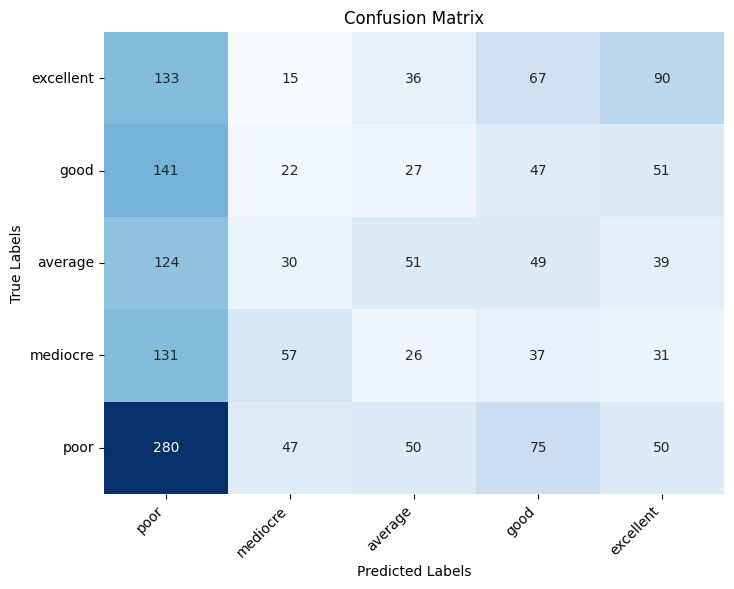

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


### Hyperparameter Tuning

In [ ]:
# Define the model building function
def build_model(hp):
    # Load the pre-trained model
    base_model = InceptionResnetv2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Add custom layers on top of the base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the InceptionV3 base
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='hyperparameter_tuning')

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'hyper_InceptionResnetv2_weights.h5'))

Epoch 1/100
171/171 [==============================] - 22s 63ms/step - loss: 1.6313 - accuracy: 0.2738 - val_loss: 1.5674 - val_accuracy: 0.2874
Epoch 2/100
171/171 [==============================] - 6s 36ms/step - loss: 1.5468 - accuracy: 0.3101 - val_loss: 1.5564 - val_accuracy: 0.3094
Epoch 3/100
171/171 [==============================] - 6s 36ms/step - loss: 1.5206 - accuracy: 0.3279 - val_loss: 1.5867 - val_accuracy: 0.2639
Epoch 4/100
171/171 [==============================] - 6s 37ms/step - loss: 1.5022 - accuracy: 0.3431 - val_loss: 1.5733 - val_accuracy: 0.2977
Epoch 5/100
171/171 [==============================] - 6s 37ms/step - loss: 1.4828 - accuracy: 0.3508 - val_loss: 1.5862 - val_accuracy: 0.3050
Epoch 6/100
171/171 [==============================] - 6s 37ms/step - loss: 1.4604 - accuracy: 0.3636 - val_loss: 1.5681 - val_accuracy: 0.2889
Epoch 7/100
171/171 [==============================] - 6s 37ms/step - loss: 1.4385 - accuracy: 0.3781 - val_loss: 1.5457 - val_accuracy

In [ ]:
# Evaluate the model
hyper_InceptionResnetv2_test_loss, hyper_InceptionResnetv2_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_InceptionResnetv2_test_loss)
print("Test Accuracy:", hyper_InceptionResnetv2_test_accuracy)

54/54 [==============================] - 2s 30ms/step - loss: 1.7253 - accuracy: 0.2837
Test Loss: 1.7252533435821533
Test Accuracy: 0.28370457887649536


### Fine Tuning

#### Load Model

In [ ]:
InceptionResnetv2, preprocess_input = Classifiers.get('inceptionresnetv2')

# Load the pre-trained model
base_model = InceptionResnetv2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/hyper_InceptionResnetv2_weights.h5'
model.load_weights(weights_path)

In [ ]:
# Evaluate the model
hyper_InceptionResnetv2_test_loss, hyper_InceptionResnetv2_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_InceptionResnetv2_test_loss)
print("Test Accuracy:", hyper_InceptionResnetv2_test_accuracy)

54/54 [==============================] - 7s 29ms/step - loss: 1.7253 - accuracy: 0.2837
Test Loss: 1.7252533435821533
Test Accuracy: 0.28370457887649536


In [ ]:
# Load the pre-trained model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Unfreeze some layers for fine-tuning
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'fine_InceptionResNetV2_weights.h5'))


Epoch 1/100
171/171 [==============================] - 21s 62ms/step - loss: 1.6258 - accuracy: 0.2683 - val_loss: 1.5654 - val_accuracy: 0.2969
Epoch 2/100
171/171 [==============================] - 6s 37ms/step - loss: 1.5560 - accuracy: 0.3046 - val_loss: 1.5612 - val_accuracy: 0.3043
Epoch 3/100
171/171 [==============================] - 6s 37ms/step - loss: 1.5325 - accuracy: 0.3182 - val_loss: 1.5572 - val_accuracy: 0.3174
Epoch 4/100
171/171 [==============================] - 6s 37ms/step - loss: 1.5168 - accuracy: 0.3317 - val_loss: 1.5671 - val_accuracy: 0.3328
Epoch 5/100
171/171 [==============================] - 6s 38ms/step - loss: 1.4924 - accuracy: 0.3530 - val_loss: 1.5579 - val_accuracy: 0.3277
Epoch 6/100
171/171 [==============================] - 7s 38ms/step - loss: 1.4635 - accuracy: 0.3701 - val_loss: 1.5628 - val_accuracy: 0.3138
Epoch 7/100
171/171 [==============================] - 7s 39ms/step - loss: 1.4524 - accuracy: 0.3745 - val_loss: 1.5563 - val_accuracy

In [ ]:
InceptionResnetv2, preprocess_input = Classifiers.get('inceptionresnetv2')

# Load the pre-trained model
base_model = InceptionResnetv2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/fine_InceptionResNetV2_weights.h5'
model.load_weights(weights_path)

In [ ]:
# Evaluate the model
fine_InceptionV3_test_loss, fine_InceptionV3_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", fine_InceptionV3_test_loss)
print("Test Accuracy:", fine_InceptionV3_test_accuracy)

54/54 [==============================] - 7s 30ms/step - loss: 3.1950 - accuracy: 0.3271
Test Loss: 3.1949751377105713
Test Accuracy: 0.3270809054374695


54/54 [==============================] - 5s 26ms/step


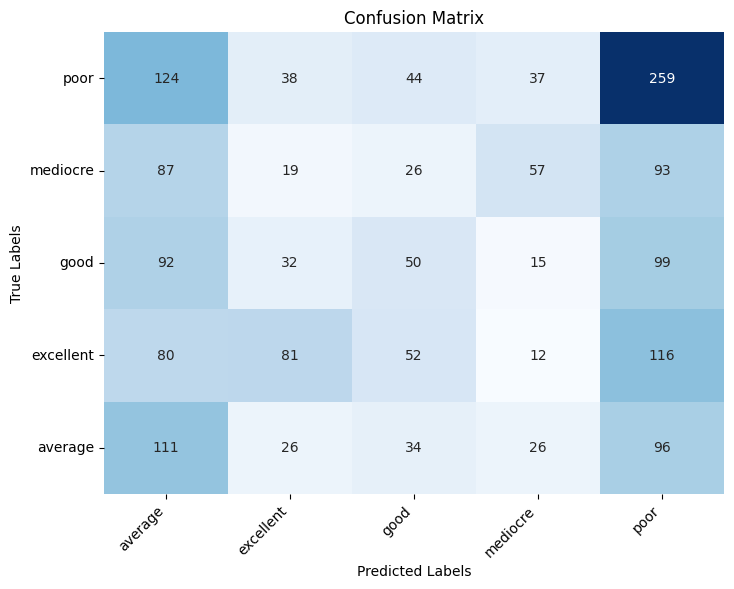

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=list(mapping_dict.values()))

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = list(mapping_dict.values())
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


54/54 [==============================] - 1s 25ms/step


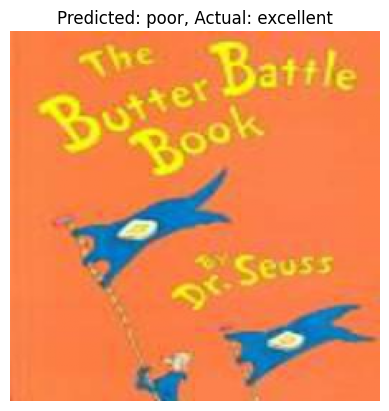

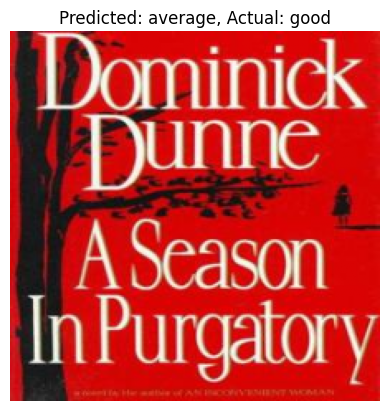

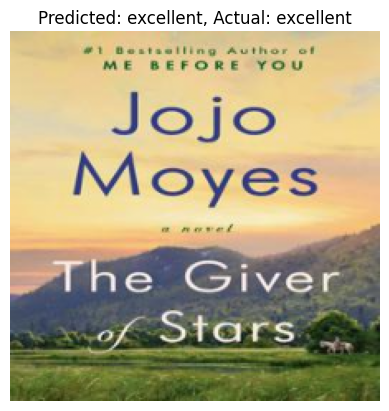

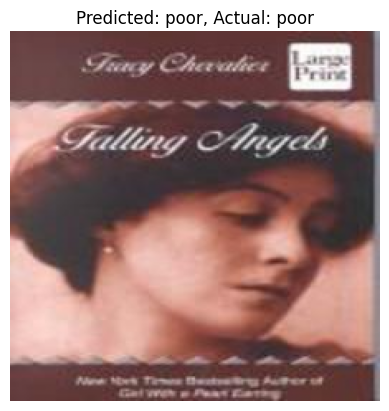

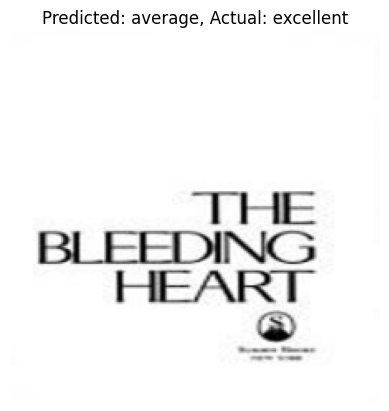

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Print out some images along with their predicted and actual labels
num_examples = 5

for i in range(num_examples):
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {y_pred_decoded[i]}, Actual: {y_test_decoded[i]}")
    plt.axis('off')
    plt.show()


## DenseNet

### Train Model

In [ ]:
DenseNet201, preprocess_input = Classifiers.get('densenet201')

# Load the pre-trained model
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model and display loss and accuracy
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss and accuracy from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Display loss and accuracy during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'DenseNet201_weights.h5'))

74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/100
171/171 [==============================] - 22s 66ms/step - loss: 1.6134 - accuracy: 0.2846 - val_loss: 1.5635 - val_accuracy: 0.3065
Epoch 2/100
171/171 [==============================] - 7s 41ms/step - loss: 1.5228 - accuracy: 0.3273 - val_loss: 1.5600 - val_accuracy: 0.3152
Epoch 3/100
171/171 [==============================] - 7s 41ms/step - loss: 1.4823 - accuracy: 0.3519 - val_loss: 1.6033 - val_accuracy: 0.3233
Epoch 4/100
171/171 [==============================] - 7s 41ms/step - loss: 1.4390 - accuracy: 0.3860 - val_loss: 1.5928 - val_accuracy: 0.3138
Epoch 5/100
171/171 [==============================] - 7s 40ms/step - loss: 1.3668 - accuracy: 0.4348 - val_loss: 1.6416 - val_accuracy: 0.2705
Epoch 6/100
171/171 [==============================] - 7s 40ms/step - loss: 1.3029 - accuracy: 0.4580 - val_loss: 1.6115 - val_accuracy: 0.3218
Epoch 7/100
171/171 [==============================] - 7s 41ms/step - 

#### Confusion matrix

In [ ]:
# Evaluate the model
DenseNet201_test_loss, DenseNet201_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", DenseNet201_test_loss)
print("Test Accuracy:", DenseNet201_test_accuracy)

54/54 [==============================] - 2s 34ms/step - loss: 1.8897 - accuracy: 0.3142
Test Loss: 1.889729380607605
Test Accuracy: 0.314185231924057


54/54 [==============================] - 6s 29ms/step


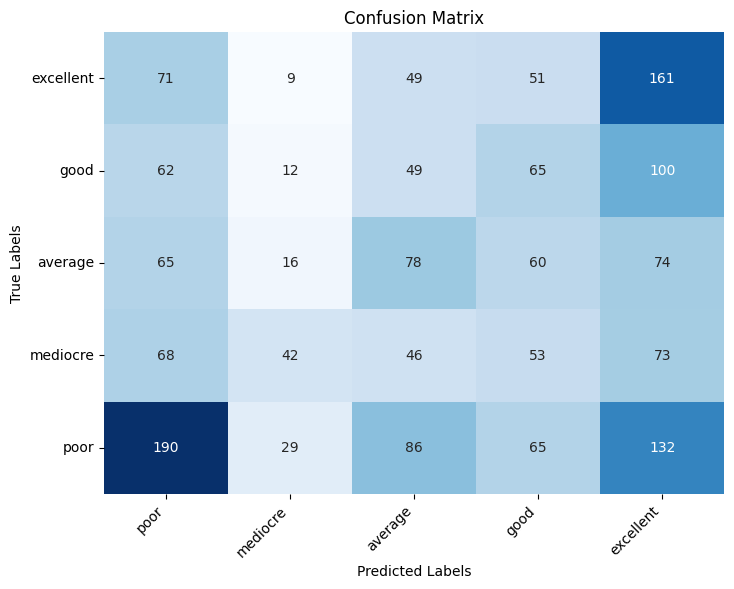

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


### Hyperparameter Tuning

In [ ]:
# Define the model building function
def build_model(hp):
    # Load the pre-trained model
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Add custom layers on top of the base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='hyperparameter_tuning')

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'hyper_DenseNet201_weights.h5'))

Epoch 1/100
171/171 [==============================] - 22s 66ms/step - loss: 1.6200 - accuracy: 0.2813 - val_loss: 1.5656 - val_accuracy: 0.2940
Epoch 2/100
171/171 [==============================] - 7s 42ms/step - loss: 1.5291 - accuracy: 0.3301 - val_loss: 1.5822 - val_accuracy: 0.3057
Epoch 3/100
171/171 [==============================] - 7s 41ms/step - loss: 1.4964 - accuracy: 0.3504 - val_loss: 1.5760 - val_accuracy: 0.2955
Epoch 4/100
171/171 [==============================] - 7s 41ms/step - loss: 1.4578 - accuracy: 0.3755 - val_loss: 1.5789 - val_accuracy: 0.3145
Epoch 5/100
171/171 [==============================] - 7s 41ms/step - loss: 1.3985 - accuracy: 0.4084 - val_loss: 1.5865 - val_accuracy: 0.3292
Epoch 6/100
171/171 [==============================] - 7s 41ms/step - loss: 1.3511 - accuracy: 0.4417 - val_loss: 1.6139 - val_accuracy: 0.3262
Epoch 7/100
171/171 [==============================] - 7s 42ms/step - loss: 1.2962 - accuracy: 0.4710 - val_loss: 1.6154 - val_accuracy

### Fine Tuning

#### Load Model

In [ ]:
DenseNet201, preprocess_input = Classifiers.get('densenet201')

# Load the pre-trained model
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights from a path
weights_path = '/content/drive/MyDrive/covers/model_1_weights/hyper_DenseNet201_weights.h5'
model.load_weights(weights_path)

In [ ]:
# Evaluate the model
hyper_DenseNet201_test_loss, hyper_DenseNet201_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", hyper_DenseNet201_test_loss)
print("Test Accuracy:", hyper_DenseNet201_test_accuracy)

54/54 [==============================] - 7s 33ms/step - loss: 1.7859 - accuracy: 0.3265
Test Loss: 1.78591787815094
Test Accuracy: 0.3264947235584259


In [ ]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Unfreeze some layers for fine-tuning
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_1_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'fine_DenseNet201_weights.h5'))

Epoch 1/100
171/171 [==============================] - 23s 65ms/step - loss: 1.6196 - accuracy: 0.2793 - val_loss: 1.5715 - val_accuracy: 0.2991
Epoch 2/100
171/171 [==============================] - 7s 41ms/step - loss: 1.5281 - accuracy: 0.3277 - val_loss: 1.5569 - val_accuracy: 0.3145
Epoch 3/100
171/171 [==============================] - 7s 40ms/step - loss: 1.4781 - accuracy: 0.3644 - val_loss: 1.5842 - val_accuracy: 0.2999
Epoch 4/100
171/171 [==============================] - 7s 41ms/step - loss: 1.4173 - accuracy: 0.3997 - val_loss: 1.6065 - val_accuracy: 0.3087
Epoch 5/100
171/171 [==============================] - 7s 41ms/step - loss: 1.3595 - accuracy: 0.4393 - val_loss: 1.6151 - val_accuracy: 0.3226
Epoch 6/100
171/171 [==============================] - 7s 41ms/step - loss: 1.3018 - accuracy: 0.4595 - val_loss: 1.6515 - val_accuracy: 0.3204
Epoch 7/100
171/171 [==============================] - 7s 41ms/step - loss: 1.2099 - accuracy: 0.5205 - val_loss: 1.6613 - val_accuracy

In [ ]:
# Evaluate the model
fine_DenseNet201_test_loss, fine_DenseNet201_test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", fine_DenseNet201_test_loss)
print("Test Accuracy:", fine_DenseNet201_test_accuracy)

54/54 [==============================] - 2s 32ms/step - loss: 3.3128 - accuracy: 0.2995
Test Loss: 3.3128464221954346
Test Accuracy: 0.29953107237815857


54/54 [==============================] - 6s 29ms/step


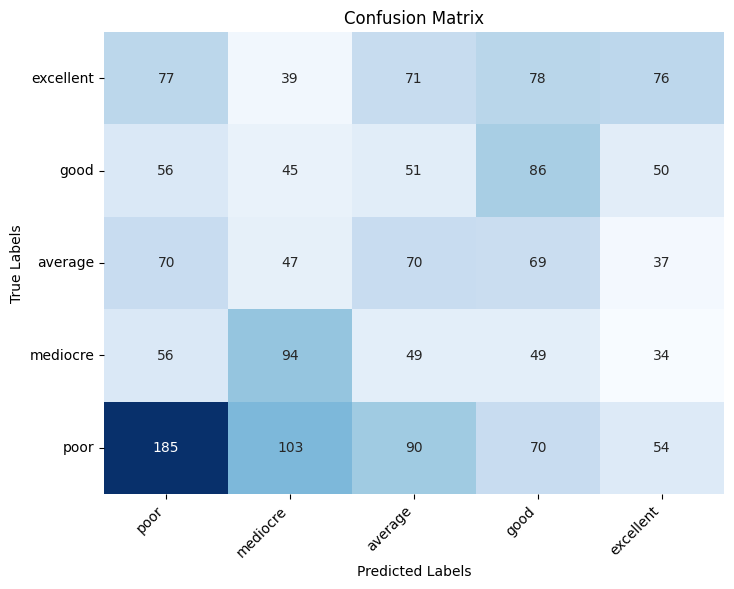

In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()
